# Period of a Pendulum

We begin our exploration of *computational physics* with an example from mechanics.  We will consider the motion of a pendulum.  

Imagine a pendulum of length $L$ is pulled up to make an angle $\theta$ with respect the the vertical.  

<img src="https://docs.google.com/drawings/d/e/2PACX-1vTwUJDECXEo0ZeyJ-i5zonaMAytMBHm8IfrIwfRnYMoiTKyvSUGirVm9lXpy63JJHaUsopfbYRRZ74J/pub?w=877&amp;h=718">

The component of the graviational force which is in the direction of motion is $F_\parallel=-m g \sin(\theta)$.  The speed of the bob is $v=L d\theta/dt$.  Thus we get equations of motion

\begin{align}
\frac{d \theta}{dt}&= \frac{v}{L} \\
m \frac{d v}{dt}&=-m g \sin(\theta)
\end{align}

We know the pendulum will swing back and forth.  We want to calculate its period.

The classic approach is to use energy arguments.  The kinetic energy of the pendulum is
\begin{equation}
T=\frac{1}{2}m v^2.
\end{equation}
The potential energy is
\begin{equation}
U=-mgL \cos(\theta).
\end{equation}
Then the total energy is
\begin{equation}
E=\frac{1}{2}m v^2-mgL \cos(\theta).
\end{equation}
Since the total energy is conserved we can solve this for the velocity:
\begin{equation}
v = \sqrt{\frac{2 E}{m} +2 gL \cos(\theta)}
\end{equation}
Our argument is slightly simpler if we note that the energy can be related to the maximum angle that the pendulum reaches, $\theta_m$, so:
\begin{equation}
v = \sqrt{2 g L}\sqrt{\cos(\theta)-\cos(\theta_m)}
\end{equation}
Next we note that $v=Ld\theta/dt$ and hence
\begin{equation}
\frac{d\theta}{dt}=
\sqrt{\frac{2g}{L}}
\sqrt{\cos(\theta)-\cos(\theta_m})
\end{equation}

We then note that a quarter period is the time it takes for the pendulum to rise from $\theta=0$ to $\theta=\theta_m$, and hence
\begin{equation}
\frac{T}{4}=\int_{t_0}^{t_m}\!dt=\sqrt{\frac{L}{2g}}\int_0^{\theta_m}\frac{d\theta}{\sqrt{\cos(\theta)-\cos(\theta_m)}}
\end{equation}

This integral is an *elliptic integral*.  It has no closed form in terms of more elementary functions.  Thus we need to develop numerical methods to evaluate it.

The task of evaluating integrals is known as *quadratures*.

<div style="border: 2px solid white; border-radius: 10px; padding: 20px; background-color:white; color:black; height: 500px" >
</div>

## Adimensionalizing

A good first step in any numerical calculation is to *adimensionalize* your equations.  This is actually a good step in analytic work as well.

We will learn how to systematically do this, but here I know that for small amplitudes the period of a pendulum is 
\begin{equation}
T_{0}=2\pi \sqrt{\frac{L}{g}}.
\end{equation}
This it makes sense for us to calculate
\begin{equation}
\bar T =\frac{T}{T_0}=\frac{\sqrt{2}}{\pi}\int_0^{\theta_m}\frac{d\theta}{\sqrt{\cos(\theta)-\cos(\theta_m)}}
\end{equation}

The angle $\theta_m$ is already dimensionless, so we can leave it as-is.

<div style="border: 2px solid white; border-radius: 10px; padding: 20px; background-color:white; color:black; height: 500px" >
</div>

## Strategies

We have several strategies we could pursue now:

1. Type into google "Numerical Integration in Julia".  Download the right package and do the integral.
2. Write our own integrator.

Both are useful.  The advantage of the package is that it will probably get us results sooner.  The advantage of writing our own is that we can tweak it to meet our needs.  Also, we will learn a lot from writing the integrator.

We are going to try to walk the line here -- both giving you the skills to work with low-level algorithms -- and the ability to take advantage of high level packages.

It is also worth noting that there is work involved with learning how to use a package.  Generally it will be less work than writing your own routines -- but that outlay should not be discounted.

<div style="border: 2px solid white; border-radius: 10px; padding: 20px; background-color:white; color:black; height: 500px" >
</div>

## Simple approaches to numerical quadratures

Reading: <a href="http://numerical.recipes/book.html">Chapter 4 of Numerical Recipies</a>

The basic idea with most quadrature approaches is to break the integral into discrete segments, and then approximate the integral on each of those segments.  One straightforward approach is the "trapezoid rule" where one breaks each segment into trapezoids:

In [1]:
using Plots,LaTeXStrings #load in visualization software

In [2]:
"""
    showtrapezoids(f,range=(0,1),n=5;opts...)

Illustrates trapezoid rule by plotting the function `f` over the range specified by `range`.
Show `n` trapezoids overlayed.  Passes on options `opts` to the plot command.
"""
function showtrapezoids(f,range=(0,1),n=5;opts...)
    # define variables
    xmin=range[1]
    xmax=range[2]
    # Create basic plot of function
    plt=plot(f,xmin,xmax,xlabel="x",ylabel="f",legend=false,show=false,opts...)
    #
    # Draw trapezoids
    #
    function trapezoid(j)
        width=(xmax-xmin)/n
        x1=(j-1)*width
        x2=j*width
        y1=f(x1)
        y2=f(x2)
        Shape([x1, x1, x2, x2],[0,y1,y2,0])
    end
    for j in 1:n
        plot!(trapezoid(j),opacity=0.2)
    end
    plt
end

showtrapezoids

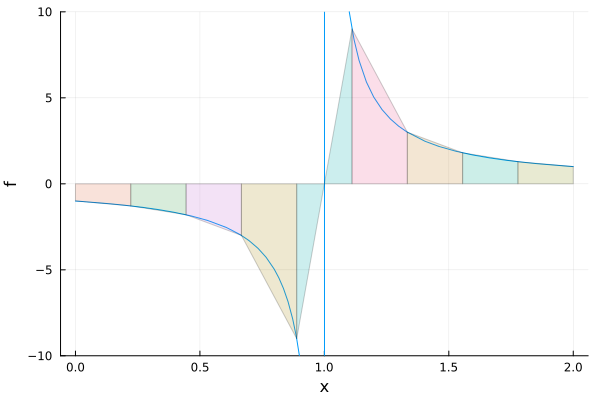

In [37]:
f(x)=1/(x-1)
showtrapezoids(f,(0,2),9)
ylims!(-10,10)

### Naive implementation of trapezoid rule

Lets not worry about efficiency, and write the simplest implementation of the trapezoid rule that we can think of.  We will make this more efficient later -- but this version is already fast enough for our purposes.  One of the points of using Julia is that the naive implementation of algorithms tends to be fast.

In [9]:
"""
    naive_trap(f,range,n)

is a naive implementation of the trapezoid rule for calculating
`∫f(x)dx`, with `x` running between `a` and `b` where `range=(a,b)`.
The integral region is divided into `n` trapezoids.
"""
function naive_trap(f,range,n)
    result=0.
    xmin=range[1]
    xmax=range[2]
    dx=(xmax-xmin)/n
    for j in 1:n
        x1=xmin+(j-1)*dx
        x2=x1+dx
        result+= (f(x2)+f(x1))*dx/2
    end
    return result
end

naive_trap

At the beginning of the function I supplied a "docstring".  This allows one to use the interactive help feature to learn about the function

In [10]:
?naive_trap

search: naive_trap



```
naive_trap(f,range,n)
```

is a naive implementation of the trapezoid rule for calculating `∫f(x)dx`, with `x` running between `a` and `b` where `range=(a,b)`. The integral region is divided into `n` trapezoids.


In [13]:
testf(x)=sin(x)
naive_trap(testf,(0,pi),100)

1.999835503887444

Notationally that is fine -- but for things like this it is nice to be able to pass around "pure functions" or "lambda functions" or "anonymous functions"  

In [15]:
naive_trap(x->x^3,(0,1),100)

0.25002500000000005

In that expression, `x->x^3` is short-hand for creating the function like `testf`, and then inserting it into the function call.  Here are a couple more examples of using this notation.

In [16]:
(x->x^2)(4)

16

In [17]:
g=(x->x+2)
g(5)

7

In [18]:
function f(x)
    y=x+1
    y^2+2
end

f (generic function with 1 method)

In [19]:
f(0)

3

Julia also has a slightly obtuse notation that we can use here, namely a `do` block: where the function is placed on the next line:

In [20]:
naive_trap((0,1),10) do x
    y=x+1
    return y^2+2
end

4.335

That block was equivalent to writing

In [ ]:
function f(x)
    x^2
end

naive_trap(f,(0,1),10)

I am a bit ambivalent about the `do` block notation.  I think it is solving a problem which doesn't exist -- and it leads to hard to read code.  Nonethless, it is valid syntax, so is probably good to know.  Functions which do file IO often use that notation, as does some of the asynchronous programming stuff that we will work with later. 

<div style="border: 2px solid white; border-radius: 10px; padding: 20px; background-color:white; color:black; height: 500px" >
</div>

Now, one thing I hate is remembering exactly the notation for a function definition.  A nice trick in Julia is to give multiple versions of the function that will work for any natural notation.

In [21]:
# alternate signature
naive_trap(f,a,b,n)=naive_trap(f,(a,b),n) 
#keyword arguments
naive_trap(;f,range,n)=naive_trap(f,range,n)
naive_trap(f;range,n=10)=naive_trap(f,range,n)

naive_trap (generic function with 4 methods)

Here are now all the different ways we can call our function

In [22]:
# the original way 
#-- matches `naive_trap(f,range,n)`
naive_trap(x->x^2,(0,2),4) 

2.75

In [23]:
# matches `naive_trap(f,a,b,n)`
naive_trap(x->x^2,0,2,4) 

2.75

In [24]:
# uses keyword arguments
naive_trap(;f=(x->x^2),range=(0,2),n=4) 

2.75

Note, the semicolon is actually optional, and it is happy with

In [25]:
naive_trap(f=(x->x^2),range=(0,2),n=4) 

2.75

Order doesn't matter for named arguments

In [26]:
naive_trap(n=4,f=(x->x^2),range=(0,2))

2.75

We can also package up the arguments into a container.  This is useful if we are going to be using the same arguments in multiple places in our code.  There will be fewer errors if we move them as a package

In [27]:
dictargs=Dict(:f=>(x->x^2),:range=>(0,2),:n=>4)
naive_trap(;dictargs...)

2.75

In [28]:
ntupleargs=(f=(x->x^2),:range=>(0,2),n=4)
naive_trap(;ntupleargs...)

2.75

In [29]:
args=(x->x^2,(0,2),4)
naive_trap(args...)

2.75

**<span style="color: red;">Tuesday Aug 26 -- Lecture End Point</span>**

<div style="border: 2px solid white; border-radius: 10px; padding: 20px; background-color:white; color:black; height: 500px" >
</div>

#### Choosing `n`

How big of `n` should we use?  Lets see how our result depends on `n`

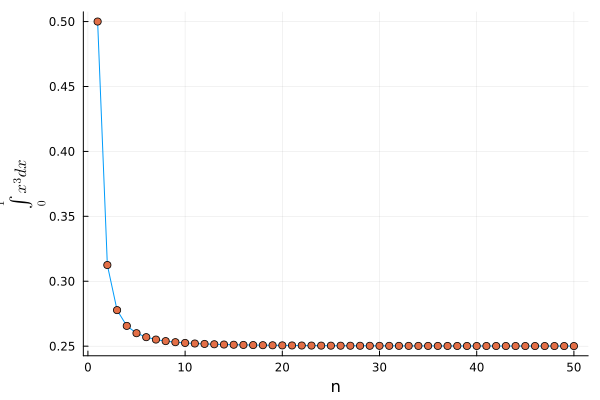

In [38]:
nvals=1:50
tvals=[naive_trap(x->x^3,(0,1),n) for n in nvals]
plot(nvals,tvals,xlabel="n",ylabel=L"$\int_0^1x^3dx$",legend=false)
scatter!(nvals,tvals)

We see that this converges pretty quickly. One trick to understand this is to rescale one of the axes.  Lets try plotting the difference beteen the exact result and this approximation, as a function of $1/n$.

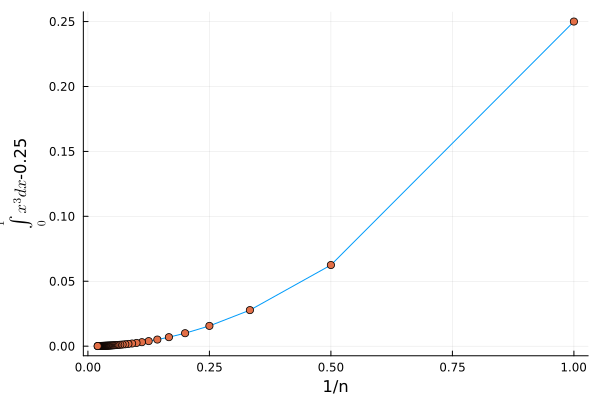

In [39]:
plot(1 ./nvals,tvals.-0.25,xlabel="1/n",
    ylabel=L"$\int_0^1x^3dx$-0.25",legend=false)
scatter!(1 ./nvals,tvals.-0.25)

The notation `tvals.-0.25` or `1 ./nvals` means to apply the operation elementwise.

In [43]:
x=[1,2,3]

3-element Vector{Int64}:
 1
 2
 3

In [41]:
x .-0.25

(0.75, 1.75, 2.75)

In [44]:
x-0.25

LoadError: MethodError: no method matching -(::Vector{Int64}, ::Float64)
For element-wise subtraction, use broadcasting with dot syntax: array .- scalar

[0mClosest candidates are:
[0m  -([91m::Missing[39m, ::Number)
[0m[90m   @[39m [90mBase[39m [90m[4mmissing.jl:123[24m[39m
[0m  -([91m::BigFloat[39m, ::Union{Float16, Float32, Float64})
[0m[90m   @[39m [90mBase[39m [90m[4mmpfr.jl:506[24m[39m
[0m  -([91m::Complex{Bool}[39m, ::Real)
[0m[90m   @[39m [90mBase[39m [90m[4mcomplex.jl:326[24m[39m
[0m  ...


Aside over -- Lets now look at that plot

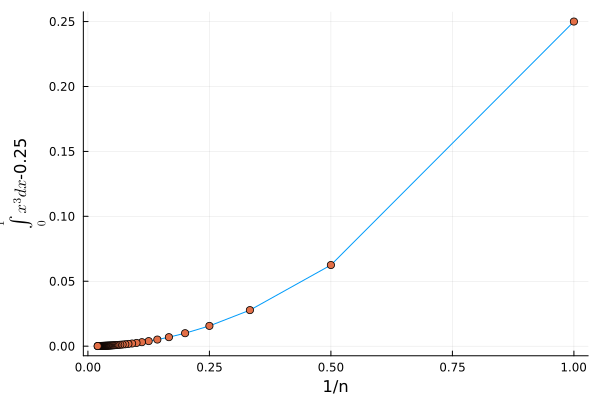

In [45]:
plot(1 ./nvals,tvals.-0.25,
    xlabel="1/n",
    ylabel=L"$\int_0^1x^3dx$-0.25",
    legend=false)
scatter!(1 ./nvals,tvals.-0.25)

It kind of looks like a parabola.  Lets plot against `1/n^2`

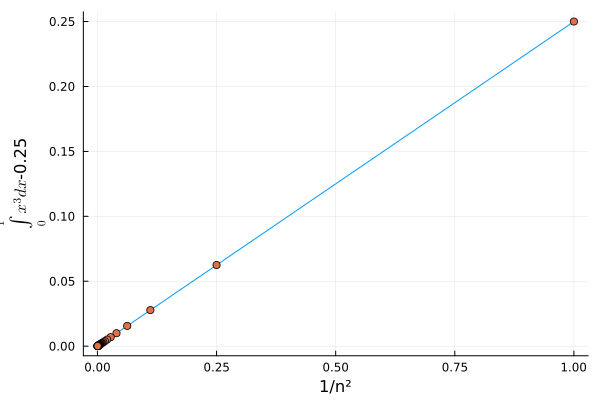

In [46]:
plot(1 ./nvals.^2,tvals.-0.25,
    xlabel="1/n²",
    ylabel=L"$\int_0^1x^3dx$-0.25",
    legend=false)
scatter!(1 ./nvals.^2,tvals.-0.25)

Apparently the error scales as $1/n^2$

An even better approach is to use a log-log plot

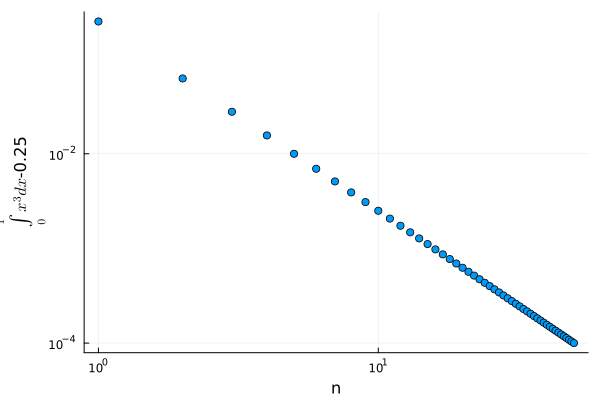

In [47]:
scatter(nvals,abs.(-(tvals.-0.25)),
    xlabel="n",
    ylabel=L"$\int_0^1x^3dx$-0.25",
    legend=false,xaxis=:log, 
    yaxis=:log)

If a plot of $\log(y)$  vs $\log(x)$ is a a straight line:  $\log(y)=a+b \log(x)$, then $y$ and $x$ are related by a power law:  $y=\alpha x^\beta$, where $\alpha=\exp(a)$ and $\beta=b$.  Lets try to fit our log-log plot to a straight line.

Later in the semester we will develop curve fitting routines, but here is a quick one.  

My curve fitting program is literally 2 lines long, and illustrates why sometimes one does not want to bother with a package.  I am sure it would take longer to Google the package than it does to write the function.

In [48]:
"""
    linearfit(X,Y,functions)

takes a set of `X=(x1,x2,...xn)`, `Y=(y1,y1,...yn)` and a set of `functions=(f1, f2,...fm)` 
and returns the set of coefficients `C=(c1,c2,..cm)` which minimize 


         n       m
    χ²=  ∑  (yi- ∑  cj fj(xi))^2
        i=1     j=1

It is implemented by constructing the `n×m` matrix `A` with matrix elements

    Aᵢⱼ= fj(xi)

then `(AᵗA)C=AᵗY`, where `Y=(y1,y2,...yn)`.  Thus the optimal coefficients are 
`(AᵗA)⁻¹(AᵗY)`, which can be implemented with `(AᵗA)\\(AᵗY)`.
"""
function linearfit(X,Y,functions)
    A=[f(x) for x in X, f in functions ]
    return transpose(A)*A\(transpose(A)*Y) # This is equivalent to (AᵗA)⁻¹(AᵗY)
end                                        # the "\" is "divide from left"

linearfit

In [49]:
?linearfit

search: linearfit



```
linearfit(X,Y,functions)
```

takes a set of `X=(x1,x2,...xn)`, `Y=(y1,y1,...yn)` and a set of `functions=(f1, f2,...fm)`  and returns the set of coefficients `C=(c1,c2,..cm)` which minimize 

```
     n       m
χ²=  ∑  (yi- ∑  cj fj(xi))^2
    i=1     j=1
```

It is implemented by constructing the `n×m` matrix `A` with matrix elements

```
Aᵢⱼ= fj(xi)
```

then `(AᵗA)C=AᵗY`, where `Y=(y1,y2,...yn)`.  Thus the optimal coefficients are  `(AᵗA)⁻¹(AᵗY)`, which can be implemented with `(AᵗA)\(AᵗY)`.


The divide from left notation may seem a little strange on a computer, but it makes sense.

In [50]:
1 / 2  # The normal way to take the ratio of 1 and 2

0.5

In [51]:
2 \ 1 # an alternative way to take the ratio of 1 and 2

0.5

In [52]:
[1 1]/[2 0;0 1] #effectively right-multipy a row vector by the right inverse

1×2 Matrix{Float64}:
 0.5  1.0

In [53]:
[2 0;0 1] \ [1;1] #effectively left-multipy a column vector by the left inverse

2-element Vector{Float64}:
 0.5
 1.0

In [54]:
lf1=linearfit(log.(nvals),log.(tvals.-0.25),(x->1.,x->x))

2-element Vector{Float64}:
 -1.3862943611198861
 -2.000000000000009

that output means that $\log(t-0.25)=-1.386 - 2\log(n)$, or in other words, $t=0.25+\exp(-1.386)n^{-2}$.

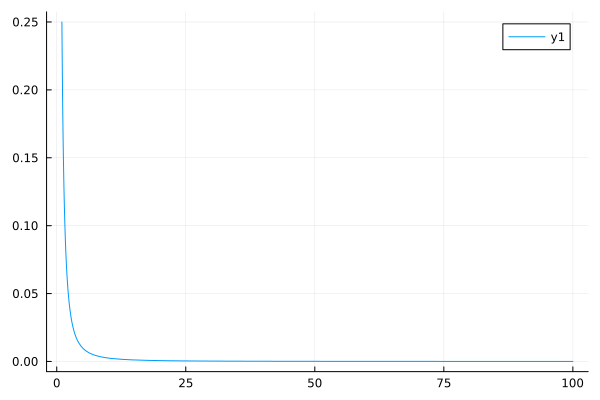

In [59]:
p1=scatter(nvals,tvals.-0.25,xlabel="n",ylabel=L"$\int_0^1x^3dx$-0.25",
    legend=false,xaxis=:log, yaxis=:log)
p2=plot(x->exp(lf1[1]+lf1[2]*log(x)),1,100)

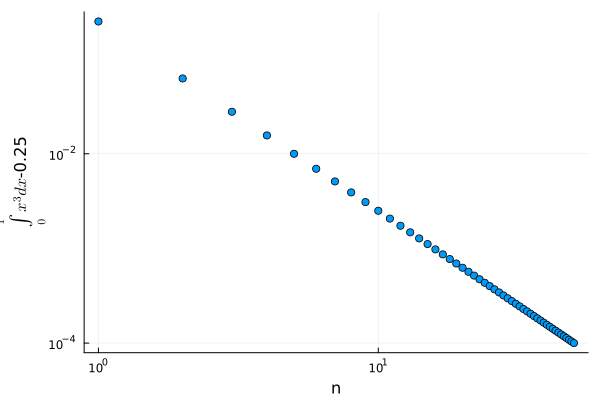

In [60]:
p1

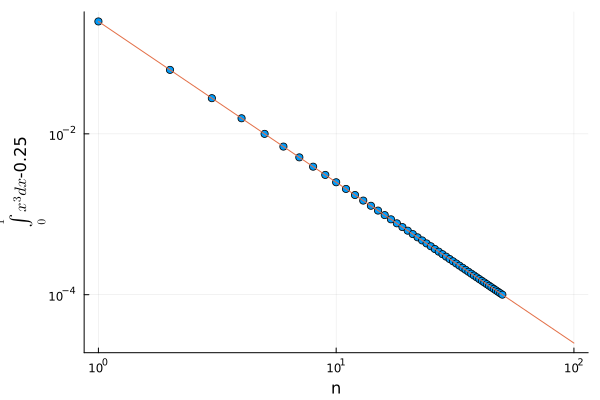

In [61]:
plot!(p1,x->exp(lf1[1]+lf1[2]*log(x)),1,100)

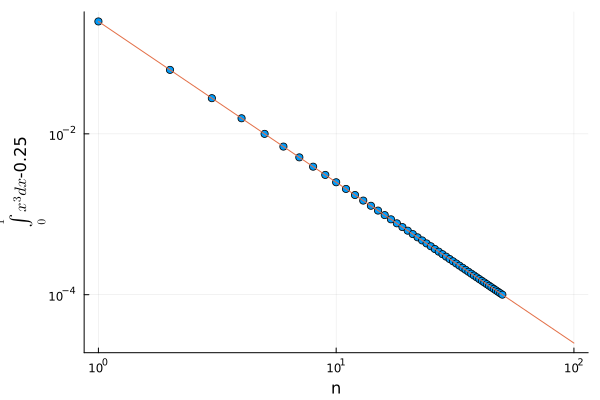

In [62]:
p1

Thus we see that the error scales as $1/n^2$.  Can we understand this?

Aside:  Can you write that last `plot!` statement as a `do` block?

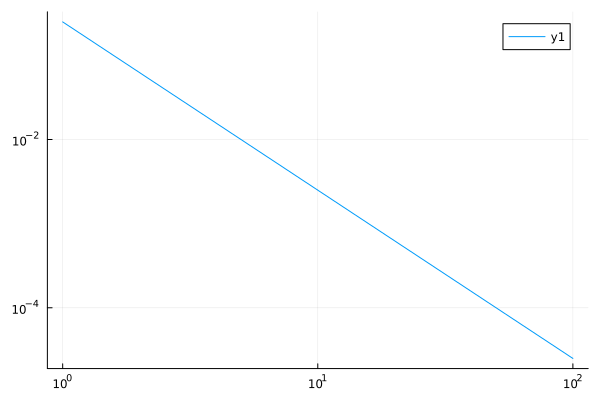

In [57]:
plot(1,100,xaxis=:log,yaxis=:log) do x
    exp(lf1[1]+lf1[2]*log(x))
end

<div style="border: 2px solid white; border-radius: 10px; padding: 20px; background-color:white; color:black; height: 500px" >
</div>

## Theory tools

### Big O Notation

We will often say that a function $f_n$ scales as $O(n^\alpha)$ as $n\to\infty$.  This means that there exists an integer $N$ and a constant $C$ such that $|f_n|\leq Cn^\alpha$ for all $n>N$.  That is, we can bound $f_n$ by some constant times $n^\alpha$.  Note that this is an upper bound, and does not mean the bound is tight.  

Here is an example showing that `y=1/(x-1)` is bounded by `2/x` for `x>1`.  Thus we say $1/(x-1)=O(x^{-1})$.

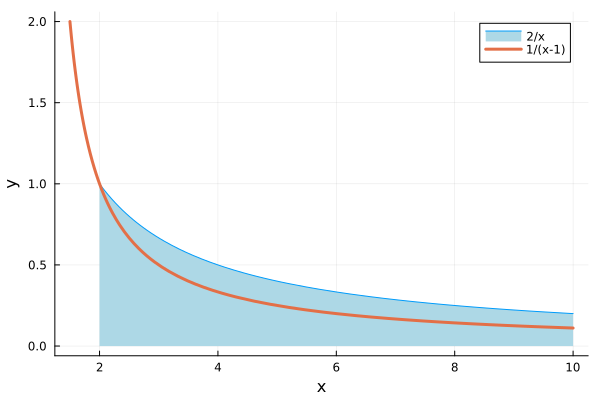

In [63]:
plot(x->2/x,2,10,fillrange = [0,0], 
    fc=:blues,label="2/x",xlabel="x",ylabel="y")
plot!(x->1/(x-1),1.5,10,label="1/(x-1)",
    linewidth=3)

Sometimes we also want to talk about tight bounds. In this course we will write $f_n\sim n^\alpha$ as $n\to\infty$ to mean that there exists a constant $C$ such that $|f_n- C n^\alpha|$ vanishes as $n\to\infty$.

In the case where $f_n$ itself vanishes as $n\to\infty$, we actually want this to be a little bit stronger, and will actually require $|f_n-C n^\alpha|/|f_n|$ vanishes as $n\to\infty$.  IE.  We want the difference between the curves to vanish faster than $f_n$ itself.

Here is an example.  We would write $1/(x-1)\sim 1/x$ as $x\to\infty$.  Note, we could also write $1/(x-1)=1/x+O(x^{-2})$, which conveys more information.

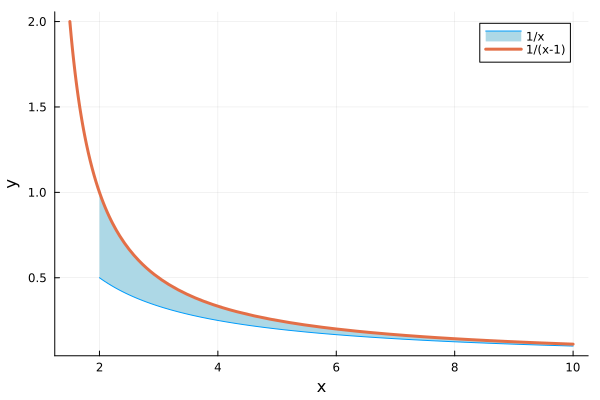

In [64]:
plot(x->1/x,2,10,fillrange = x->1/(x-1), 
    fc=:blues,label="1/x",xlabel="x",ylabel="y")
plot!(x->1/(x-1),1.5,10,label="1/(x-1)",
    linewidth=3)

We will often leave off the "$n\to\infty$" part of the statement.  Sometimes we will take a different limit -- for example we could say $f(x)=O(x^{-2})$ as $x\to0$, to mean that, for small $x$, $|f(x)|$ is bounded from above by a function proportional to $x^{-2}$.    

We can also talk about $O(g(x))$ for functions other than power laws.  

There are a [few related notations](https://en.wikipedia.org/wiki/Big_O_notation) that we will not be using.

<div style="border: 2px solid white; border-radius: 10px; padding: 20px; background-color:white; color:black; height: 500px" >
</div>

### Richardson Extrapolation

If we know that the error in the trapezoid rule scales as $n^{-2}$ we can do the integral for several values of $n$ and then fit to a function of the form $I_n=I_\infty + \epsilon n^{-2}$ -- extracting a better approximation to the integral.

In [65]:
I4=naive_trap(x->x^3,(0,1),4)

0.265625

In [66]:
I8=naive_trap(x->x^3,(0,1),8)

0.25390625

$$
I_n=I_\infty+\epsilon n^{-2}
$$

We then multiply by $n^2$,
\begin{equation}
n^2 I_n=n^2 I_\infty+\epsilon
\end{equation}

We then take two values of $n$ -- say 
$n=4$ and $n=8$.
\begin{align}
4^2 I_4 &= 4^2 I_\infty+\epsilon\\
8^2 I_8 &= 8^2 I_\infty+\epsilon
\end{align}

Subtract these
\begin{equation}
8^2 I_8-4^2 I_4= (8^2-4^2) I_\infty
\end{equation}
or
\begin{equation}
I_\infty= \frac{8^2 I_8-4^2 I_4}{8^2-4^2} =\frac{2^2 I_8-I_4}{2^2-1}
\end{equation}

In [67]:
(2^2*I8-I4)/(2^2-1)

0.25

This was exact in this case because of the form of the integrand.  In general, if we used $I_n$ and $I_{n/2}$ we would still have an error -- but instead of scaling as $n^{-2}$, it would scale as $n^{-4}$.  The approximation $I\approx (4/3)I_n-(1/3)I_{n/2}$ is known as *Simpson's Rule*

This trick can be repeated.  I can take Simpson's rule with two different $n$'s, and combine them to get an even better approximation to the integral.  This strategy is known as Romberg Integration.  This feels a bit like a free lunch.  Somehow we can get extremely accurate integrals with relatively few function evaluations.

**Caution:** Richardson extrapolation (and Romberg integration schemes) rely on our integrand being smooth.  If it is poorly behaved, then they don't necessarily help. 

<div style="border: 2px solid white; border-radius: 10px; padding: 20px; background-color:white; color:black; height: 500px" >
</div>

### Euler-Maclaurin Summation formula

A good framework for understanding these approximations in the **Euler-Maclaurin Summation Formula**.  Here is a somewhat formal derivation.  This is mostly for my own amusement -- and this *derivation* contains one or two cheats.

We will first remind you about series expansions.  Analytic functions can be written in series, such as
\begin{align}
e^x&=\sum_j \frac{x^j}{j!}\\
\frac{1}{1-x}&=\sum_j x^j.
\end{align}
Such a series is sometimes used to define a set of numbers.  We are going to need the Bernoulli numbers, which are defined by the series
$$
\frac{x}{e^{x}-1}=\sum_j \frac{B_j}{j!} x^j.
$$
One can Brute-force expand the left hand side to get
$B_0=1$, $B_1=-1/2$, $B_2=1/6$, $B_3=0$, $B_4=-1/30,\cdots$  You can easily Google them.



With Bernoulli numbers in hand we will now think about operators that act on the space of functions.  They take in a function, and spit out a new function.  For example, lets intoduce $\Delta$, which is defined by $(\Delta f)(x)=f(x+1)-f(x)$.  In Julia we can create this operator with

In [68]:
Δ(f)=(x->f(x+1)-f(x))

Δ (generic function with 1 method)

In [69]:
f1(x)=x^2
f2=Δ(f1)
@show f1(5)-f1(4)
@show f2(4);

f1(5) - f1(4) = 9
f2(4) = 9


or if that notation makes you queezy, you could also write

In [70]:
function Δ(f)
    function g(x)
        return f(x+1)-f(x)
    end
    return g
end

Δ (generic function with 1 method)

In [71]:
f1(x)=x^2
f2=Δ(f1)
@show f1(5)-f1(4)
@show f2(4);

f1(5) - f1(4) = 9
f2(4) = 9


We will next introduce $\Sigma$.  It again maps functions onto functions.  We will only need to define what it does to functions on integers.  It is defined for positive integers $x$ as
$$
(\Sigma f)(x)=\sum_{n=0}^{x-1} f(n)
$$

In [72]:
function Σ(f)
    function g(x)
        return sum(f(y) for y in 0:x-1)
    end
    return g
end

Σ (generic function with 1 method)

In [73]:
f3(n)=1
f4=Σ(f3)
f4(5)

5

I claim that $\Delta\Sigma=I$, where $I$ is the identity matrix.  To prove this one writes
\begin{align}
(\Delta\Sigma f)(x)&=(\Sigma f)(x+1)-(\Sigma f)(x)\\
&=\sum_{n=0}^x f(n) - \sum_{n=0}^{x-1} f(n).
\end{align}
All of the terms cancel except the last, which gives, $(\Delta\Sigma f)(x)=f(x)$, which shows that $\Delta\Sigma$ is the identity operator.  This makes sense, $\Delta$ and $\Sigma$ are inverses of each-other.

In the other order, however, there is a small subtlety.  We find $(\Sigma\Delta f)(x)=f(x)-f(0)$, so the order matters -- unless we restrict ourself to the space of functions which vanish at the origin. You are familliar with this structure from calculus.  The integral and the derivative are inverse operations, but the integral has an arbitrary constant in it that you need to set.  Thus the derivative of the integral of a function is the identity, but the integral of the derivative is the identity plus a constant.

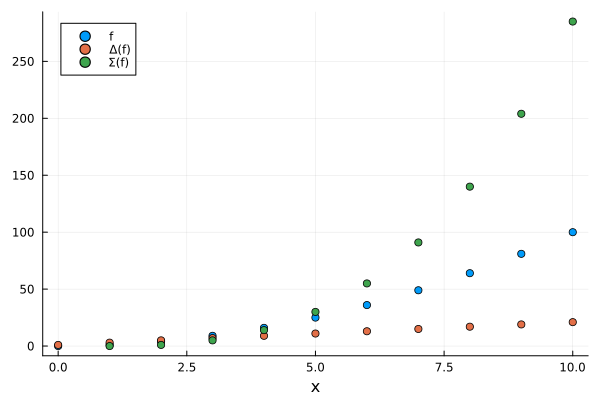

In [74]:
f(x)=x^2
scatter(0:10,f,label="f",xlabel="x")
scatter!(0:10,Δ(f),label="Δ(f)")
scatter!(1:10,Σ(f),label="Σ(f)")

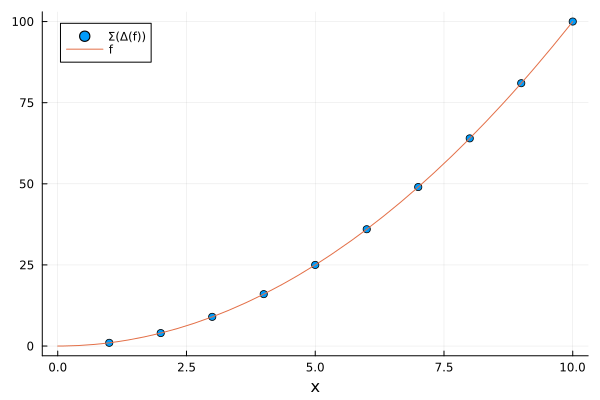

In [75]:
scatter(1:10,Σ(Δ(f)),label="Σ(Δ(f))",xlabel="x")
plot!(f,0,10,label="f")

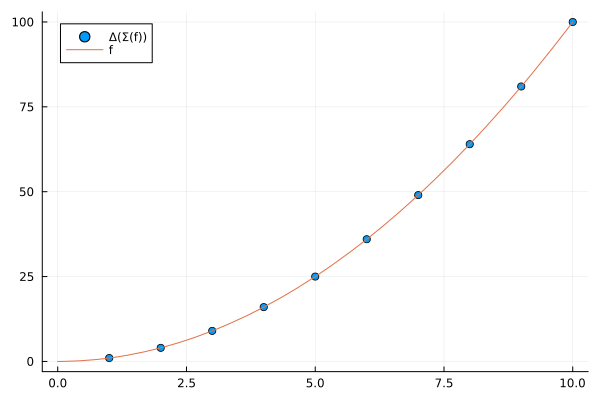

In [76]:
scatter(1:10,Δ(Σ(f)),label="Δ(Σ(f))")
plot!(f,0,10,label="f")

Next we introduce two more operators
\begin{align}
(\partial f)(x)&=f'(x)\\
(\smallint  f)(x)&=\int_0^x f(y)dy.
\end{align}
The fundamental theorem of calculus states that $\partial\smallint=  I.$  As with the $\Sigma$ and $\Delta$, if we reverse the order we get $(\smallint\partial f)(x)=f(x)-f(0)$.

Later in the course we will develop the tools to make the functions (functionals?) $\partial$ and $\smallint$.  They are clearly well defined, even if they are harder to construct than $\Sigma$ and $\Delta$.

We now turn to Taylor's theorem,
\begin{align}
f(x+1)&=f(x)+\sum_{n=1}^\infty \frac{(\partial^n f)(x)}{n!}\\
&= (e^\partial f)(x).
\end{align}
Thus Taylor's theorem can be written as $\Delta=e^{\partial}-1$

Putting this together with our previous result, $\Delta\Sigma=I$ yields
\begin{align}
\Sigma=\frac{1}{e^\partial-1}.
\end{align}
We will now multiply the right hand side by $I=\smallint \partial $ to find
\begin{align}
\Sigma=\smallint\frac{\partial}{e^\partial-1} .
\end{align}
Finally we expand the right hand side in a Taylor series:
\begin{align}
(\Sigma f)(x)&=\left(\smallint\sum_{j=0}^\infty \frac{B_j}{j!} \partial^j f\right)(x)\\
&=(\smallint f)(x) + \sum_{j=1}^\infty  \frac{B_j}{j!} \left[(\partial^{j-1} f)(x)-
(\partial^{j-1} f)(0)
\right]
\end{align}
which can be reorganized into the Euler-Maclauren summation formula
\begin{align}
\int_0^x f(y) dy &= \sum_{y=0}^{x-1} f(y) - \sum_{j=1}^\infty \frac{B_j}{j!} \left[(\partial^{j-1} f)(x)-
(\partial^{j-1} f)(0)
\right]\\
&= \sum_{y=0}^{x-1} f(y) + \frac{1}{2}[f(x)-f(0)] + \frac{B_2}{2} [f'(x)-f'(0)]+\cdots
\end{align}
The first two terms give you the trapezoid rule.  Subsequent terms give you corrections in terms of derivatives of the function at the bounds.

This may seem strange that knowledge about the behaviour of the function at the boundaries so strongly constrain the integral.  This is a peculiarity of analytic functions.

Finally we rescale the axis, taking the bounds of the integral to go from $a$ to $b$.  Thus we define $s=a+b y/n$, and $g(s)=f(n(s-a)/b)$.  Straightforward arithmetic then gives  

\begin{align}
\int_a^b g(s) ds &= \frac{1}{n}\sum_{m=0}^{n-1} g(s_m) - \sum_{j=1}^\infty \frac{B_j}{j!}\frac{1}{n^j} \left[(\partial^{j-1} g)(b)-
(\partial^{j-1} g)(a)
\right]\\
&= \frac{1}{n}\sum_{m=0}^{x-1} g(s_m) + \frac{1}{2n}[g(b)-g(a)] + \frac{B_2}{2n^2} [g'(b)-g'(a)]+O(n^{-3})
\end{align}

<div style="border: 2px solid white; border-radius: 10px; padding: 20px; background-color:white; color:black; height: 500px" >
</div>

## Improving our trapezoid rule integrator

As a reminder, here is our naive implementation of the trapezoid rule

In [77]:
function naive_trap(f,range,n)
    result=0.
    xmin=range[1]
    xmax=range[2]
    dx=(xmax-xmin)/n
    for j in 1:n
        x1=xmin+(j-1)*dx
        x2=x1+dx
        result+= (f(x2)+f(x1))*dx/2
    end
    return result
end

naive_trap (generic function with 4 methods)

**Algorithmic Inefficiencies:** 

* The function `f` is evaluated twice at every location. 
* We have `2n` muliplications by `dx`.  
* We don't use Richardson   

**Inconveniences:** 

* We need to specify `n`, the number of trapezoids, 
* We don't know how accurate our result is

Note, as discussed at the end of this notebook, there are other more subtle inefficiencies due to actual implementation by the compiler. 

### Fixing the most obvious inefficiency

The factor of 2 is easy to fix.  Instead of looping over the trapezoids we loop over the points.

In [78]:
"""
    trap(f,range,n)

is an implementation of the trapezoid rule for calculating
`∫f(x)dx`, with `x` running between `a` and `b` where `range=(a,b)`.
The integral region is divided into `n` trapezoids.
"""
function trap(f,range,n)
    xmin=range[1]
    xmax=range[2]
    dx=(xmax-xmin)/n 
    result=(f(xmin)+f(xmax))/2
    for j in 1:n-1
        result+= f(j*dx)
    end
    return result*dx
end

trap

To see a speed difference, however, one needs to go to a more complicated integrand and a very large number of trapezoids.  

In [80]:
@time naive_trap(x->sin(log(cos(x)^2+1)),
    (0.,pi),2^22)

  0.141074 seconds (5.57 k allocations: 380.609 KiB, 4.40% compilation time)


1.1222120074972937

In [81]:
@time trap(x->sin(log(cos(x)^2+1)),(0.,pi),2^22)

  0.079272 seconds (5.98 k allocations: 400.883 KiB, 11.69% compilation time)


1.1222120074971986

For smaller number of trapezoids, or simpler integrands, the time is dominated by the compiling, and this factor of 2 is irrelevant.  Note, for this example we used 4 million points -- which was certainly overkill

In [82]:
2^22

4194304

In [84]:
@time naive_trap(x->x^3,(0.,1.),1000)

  0.008540 seconds (5.17 k allocations: 352.773 KiB, 99.34% compilation time)


0.2500002499999998

In [87]:
@time trap(x->x^3,(0.,1.),1000)

  0.006009 seconds (4.78 k allocations: 316.367 KiB, 99.19% compilation time)


0.25000025000000003

Note, we can pre-compile by defining our function differently

In [88]:
h(x)=sin(log(cos(x)^2+1))
@time trap(h,(0.,1.),1000)
@time naive_trap(h,(0.,1.),1000)

  0.000018 seconds
  0.000035 seconds


0.5078618459923102

This is a good lesson: do not sweat the small stuff!

### Dynamic step size

Lets implement a strategy from *Numerical Recipies* which does the Trapezoid rule with dynamic step sizes

One reason I want to go through it, is that it introduces some useful computer science -- namely using *objects*.  *Objects* are the nouns of programs -- just as *functions* are the verbs.  There are less sophisticated ways to implement this approach, but I hope to start introducing some machinery that will be useful.

The trapezoid rule subdivides the integral into $n=2^m$ trapezoids.  We are going to sequentially increase $m$ until we achieve our desired accuracy.  In order to do this we define an object `trap_data` which stores information about the integral that you are using, and an interim result.

In [89]:
"""
    trap_data(f,range)

stores the intermediate information for our trapezoid rule. 

Fields:
    f       # store the function we are integrating
    range   # store the range (a,b)
    val     # trapezoid rule integral at current depth, m
    m       # depth -- number of trapezoids = 2ᵐ

To increase the depth use command `subdivide!` or `subdivide`.

"""
mutable struct trap_data
    f       # store the function we are integrating
    range   # store the range (a,b)
    val     # trapezoid rule integral at current depth, m
    m       # depth -- number of trapezoids = 2ᵐ
    function trap_data(f,range)
        new(f,range,(f(range[1])+f(range[2]))*(range[2]-range[1])/2,0)
    end
end

"""
    subdivide!(data ::trap_data)
takes a `trapdata` object, and doubles the number of gridpoints in the integral.
"""
function subdivide!(data ::trap_data)
    # Extract needed info from `data`
    f=data.f
    m=data.m+1
    result=zero(data.val)
    (a,b)=data.range
    # Width of new rectangles
    dx=(b-a)/2^m
    for x in dx:dx*2:dx*(2^m-1)
        result+=f(a+x)*dx
    end
    result=result+data.val/2
    # Update data
    data.m=m
    data.val=result
end

subdivide!

In [ ]:
for x in 1:0.5:25
    println(x)
end

We will learn more about this syntax as the course progresses.  Nevertheless, to see how this work, we create one of our data objects

In [90]:
td1=trap_data(x->x^3,(1,3))

trap_data(var"#89#90"(), (1, 3), 28.0, 0)

We can extract the stored information with a dot

In [91]:
td1.range

(1, 3)

In [92]:
td1.f(4)

64

In [93]:
g=td1.f

#89 (generic function with 1 method)

In [94]:
g(7)

343

In [95]:
r=td1.range

(1, 3)

In [96]:
td1.val

28.0

In [97]:
td1.m

0

In [98]:
naive_trap(td1.f,td1.range,2^td1.m)

28.0

We can then use the `subdivide!` function to break the integral into more pieces

In [99]:
subdivide!(td1)

22.0

In [100]:
td1.m

1

In [101]:
(td1.m,td1.val,naive_trap(x->x^3,(1,3),2^td1.m))

(1, 22.0, 22.0)

In [102]:
subdivide!(td1)

20.5

In [103]:
(td1.m,td1.val,naive_trap(x->x^3,(1,3),2^td1.m))

(2, 20.5, 20.5)

Every time we call subdivide we increase the number of trapezoids.  However, we just evaluate `f` at the new points.

We now just need to wrap this in a function which calls subdivide until we hit some convergence criterion.  We will use that the fractional change in the integral falls below some threshold -- that we will call `eps`.

In [ ]:
"""
`nrtrap(f,range;namedargs...)`

Uses the trapezoid rule algorithm from Numerical Recipies to calculate ``\\int_a^b f(x) dx``
where `range=(a,b)`.

`namedargs`
- `eps=1E-10`: algorithm terminates when relative change in integral falls below `eps`
- `max_divisions=20`: make no more than `max_divisions` subdivisions
- `debug=false`: set to `true` to see debug informations

"""
function nrtrap(f,range;eps=1E-10,max_divisions=20,debug=false)
    data=trap_data(f,range)
    oldval=0.
    val=0.
    for j in 1:max_divisions
        oldval=data.val
        subdivide!(data)
        val=data.val
        if abs(val-oldval)<eps*abs(oldval) || (val==0 && oldval==0)
            if debug
                print("converged after "*string(j)*" iterations")
            end
            return val
        end
    end
    error("Did not converge to precision $eps ",
          "after $max_divisions subdivisions.\n",
          "Previous 2 results: ($oldval,$val)\n\n",
        "Try increasing number of divisions or applying a tranformation to integrand.")
end

**Question?**  Why does it make sense to use that stopping criterion?

    abs(val-oldval)<eps*abs(oldval)

When might it make less sense?

In [ ]:
"a"*"b"

In [ ]:
nrtrap(x->x^3,(0,1),debug=true)

In [ ]:
nrtrap(x->x^4,(0,1),debug=true,max_divisions=4,eps=1e-12)

It is a simple change to upgrade this to Simpson's rule

In [ ]:
"""
`nrsimp(f,range;namedargs...)`

Uses the Simpson's rule algorithm from Numerical Recipies to calculate ``\\int_a^b f(x) dx``
where `range=(a,b)`.

`namedargs`
- `eps=1E-10`: algorithm terminates when relative change in integral falls below `eps`
- `max_divisions=20`: make no more than `max_divisions` subdivisions
- `debug=false`: set to `true` to see debug informations

"""
function nrsimp(f,range;eps=1E-10,max_divisions=20,debug=false)
    data=trap_data(f,range)
    oldtrapval=data.val
    subdivide!(data)
    trapval=data.val
    sval=(4*trapval-oldtrapval)/3
    oldsval=sval
    for j in 2:max_divisions
        oldtrapval=trapval
        oldsval=sval
        subdivide!(data)
        trapval=data.val
        sval=(4*trapval-oldtrapval)/3
        if abs(sval-oldsval)<eps*abs(oldsval) || (sval==0 && oldsval==0)
            if debug
                print("converged after "*string(j)*" iterations")
            end
            return sval
        end
    end
    error("Did not converge to precision $eps ",
          "after $max_divisions subdivisions.\n",
          "Previous 2 results: ($oldsval,$sval)\n\n",
        "Try increasing number of divisions or applying a tranformation to integrand.")
end

In [ ]:
nrsimp(x->x^4*log(x+sqrt(1+x^2)),(0,2),debug=true)

In [ ]:
nrtrap(x->x^4*log(x+sqrt(1+x^2)),(0,2),debug=true)

In [ ]:
2^10

In [ ]:
2^18

<div style="border: 2px solid white; border-radius: 10px; padding: 20px; background-color:white; color:black; height: 500px" >
</div>

## Optimization

I probably won't get to this in class -- but you may find it useful to read.

**Note:  In general optimization is the last thing your should worry about.**

First, in a complex program there is usually one or two rate limiting steps.  It is hard to predict what these will be *a-priori*.  Optimization of any part of the code, except those rate limiting steps, is wasted.

Second, optimization is complicated.  It depends on not only the programming language, but the implementation of the language, the compiler, the compiler directives...  It is often a trial and error process -- and sometime you discover that your new approach is slower than the old.  In general clean simple code will be fast.

Regardless, lets now see how we are doing with speed

In [ ]:
@time nrtrap(x->x^3,(0,1),debug=true)

In [ ]:
@time naive_trap(x->x^3,(0,1),2^18)

Oh no! Our fancy version is about 8 times slower than our naive version.  Things are even worse if I use a pre-compiled function  

In [ ]:
h(x)=x^3

In [ ]:
@time nrtrap(h,(0,1),debug=true)

In [ ]:
@time naive_trap(h,(0,1),2^18)

Fixing this is non-trivial, as the speed of these routines depends on low level internals.  If you look at the `@time` statement for our `naive-trap` function, you see that the bulk of the time there is taken in compilation (when we feed in a pure function which is therefore not precompiled).

There is a more reliable -- but slower -- timing tool which will run the program multiple times, and subtract off the compilation time.

In [ ]:
using BenchmarkTools

In [ ]:
@btime naive_trap(x->x^3,(0,1),2^18)

In [ ]:
@btime naive_trap(h,(0,1),2^18)

In [ ]:
@btime nrtrap(x->x^3,(0,1))

In [ ]:
@btime nrtrap(h,(0,1))

One clue to the problem is that in `nrtrap` we are seeing a large number of `Heap allocations`.  This has to do with the way the fact that we are passing around a function object inside a struct, and the just-in-time compiler does not know what data type the function returns.  Thus it has to allocate memory in a generic way.

We can fix some of this by compartmentalizing the function calls in our `subdivide!` method -- making what is known as a "function barrier."  This is an optimization trick which is unique to Julia.

In [ ]:
"""
    alt3_trap_data(f,range)

stores the intermediate information for our trapezoid rule. 

Fields:
    f       # store the function we are integrating
    range   # store the range (a,b)
    val     # trapezoid rule integral at current depth, m
    m       # depth -- number of trapezoids = 2ᵐ

To increase the depth use command `subdivide!` or `subdivide`.

"""
mutable struct alt3_trap_data
    f       # store the function we are integrating
    range   # store the range (a,b)
    val     # trapezoid rule integral at current depth, m
    m       # depth -- number of trapezoids = 2ᵐ
    function alt3_trap_data(f,range)
        new(f,range,(f(range[1])+f(range[2]))*(range[2]-range[1])/2,0)
    end
end

function subdivide!(data ::alt3_trap_data)
    # Extract needed info from `data`
    f=data.f
    m=data.m+1
    range=data.range
    nextresult=sum_even_points(f,range,2^m) # compiler will generate code for this function which is specialized to the arguments
    result=nextresult+data.val/2
    # Update data
    data.m=m
    data.val=result
end

function sum_even_points(f,range,n)
    (a,b)=range
    dx=(b-a)/n
    result=f(a+dx)*dx
    for j in 3:2:n-1
        result+=f(a+j*dx)*dx
    end
    return result
end

"""
`alt3_nrtrap(f,range;namedargs...)`

Uses the trapezoid rule algorithm from Numerical Recipies to calculate ``\\int_a^b f(x) dx``
where `range=(a,b)`.

`namedargs`
- `eps=1E-10`: algorithm terminates when relative change in integral falls below `eps`
- `max_divisions=20`: make no more than `max_divisions` subdivisions
- `debug=false`: set to `true` to see debug informations

"""
function alt3_nrtrap(f,range;eps=1E-10,max_divisions=20,debug=false)
    data=alt3_trap_data(f,range)
    oldval=0.
    val=0.
    for j in 1:max_divisions
        oldval=data.val
        subdivide!(data)
        val=data.val
        if abs(val-oldval)<eps*abs(oldval) || (val==0 && oldval==0)
            if debug
                print("converged after "*string(j)*" iterations")
            end
            return val
        end
    end
    error("Did not converge to precision "*string(eps)*
          "after "*string(max_divisions)*" subdivisions."*
          "previous 2 results: ("*string(oldval)*
          ","*string(val)*")")
end

In [ ]:
@time nrtrap(x->x^3,(0.,1.),debug=true)

In [ ]:
@time alt3_nrtrap(x->x^3,(0.,1.),debug=true)

Apparently we got somewhere between a factor of 5-10 speedup

We can do even better if we precompile (or use `@btime` to get rid of the compilation timing) 

In [ ]:
@time nrtrap(h,(0.,1.),debug=true)

In [ ]:
@time alt3_nrtrap(h,(0.,1.),debug=true)

This gave us another 2 orders of magnitude in speed!!  Note the drastic reduction in heap allocations.  We are now competitive with the simplest implementation.

In [ ]:
@time trap(h,(0,1),2^18)

**Optimization is hard!**

The real magic here is that Julia is able to figure out the return type of the function and uses that information to optimize things.

In [ ]:
Base.return_types(h,(Float64,))

In [ ]:
Base.return_types(x->x^3,(Float64,))

The process of type-hinting occurs when the function is an argument of another function.  If we bury the function inside a `struct`, the compiler never does the type-hinting.  Later in the course we will learn about how to create `struct` objects which know about the types of their contents, and don't have this performance hit.  The `function barrier` approach though is always good to have in your pocket.

The other strategy which would work here is to not store `f` in our `struct`, but instead pass around 2 arguments: `f` and the data.  We also need to give concrete types to `range`, `val`, and `m`:

In [ ]:
"""
    alt2_trap_data{R,D}(f,range)

stores the intermediate information for our trapezoid rule. 

Fields:
    range   # store the range (a,b)
    val     # trapezoid rule integral at current depth, m
    m       # depth -- number of trapezoids = 2ᵐ

To increase the depth use command `subdivide!` or `subdivide`.

"""
mutable struct alt2_trap_data{D,R}   # Parameterized type:  D=domain, R=range
    range  ::Tuple{D,D}              # store the range (a,b)
    val    ::R                       # trapezoid rule integral at current depth, m
    m      ::Int64                   # depth -- number of trapezoids = 2ᵐ
    function alt2_trap_data(f,range)
        r1,r2=range
        f1=f(r1)
        f2=f(r2)
        trap=(f1+f2)*(r1+r2)/2
        new{typeof((r2-r1)/2),typeof(trap)}(range,trap,0)
    end
end

"""
    subdivide!(f,data ::alt_trap_data)
takes a `trapdata` object, and doubles the number of gridpoints in the integral.
"""
function subdivide!(f,data ::alt2_trap_data)
    # Extract needed info from `data`
    m=data.m+1
    result=data.val/2
    (a,b)=data.range
    # Width of new rectangles
    dx=(b-a)/2^m
    for x in dx:dx*2:dx*(2^m-1)
        result+=f(a+x)*dx
    end
    # Update data
    data.m=m
    data.val=result
end

"""
`alt_nrtrap(f,range;namedargs...)`

Uses the trapezoid rule algorithm from Numerical Recipies to calculate ``\\int_a^b f(x) dx``
where `range=(a,b)`.

`namedargs`
- `eps=1E-10`: algorithm terminates when relative change in integral falls below `eps`
- `max_divisions=20`: make no more than `max_divisions` subdivisions
- `debug=false`: set to `true` to see debug informations

"""
function alt2_nrtrap(f,range;eps=1E-10,max_divisions=20,debug=false)
    data=alt2_trap_data(f,range)
    oldval=zero(f(range[1]))
    val=oldval
    for j in 1:max_divisions
        oldval=data.val
        subdivide!(f,data)
        val=data.val
        if abs(val-oldval)<eps*abs(oldval) || (val==0 && oldval==0)
            if debug
                print("converged after "*string(j)*" iterations")
            end
            return val
        end
    end
    error("Did not converge to precision $eps ",
          "after $max_divisions subdivisions.\n",
          "Previous 2 results: ($oldval,$val)\n\n",
        "Try increasing number of divisions or applying a tranformation to integrand.")
end

In [ ]:
h(x)=x^3
@btime alt2_nrtrap(h,(0.,1.),debug=false)

In [ ]:
@btime alt2_nrtrap(h,(0.,1.),debug=false)

In [ ]:
@btime alt3_nrtrap(h,(0.,1.),debug=false)

In [ ]:
@btime trap(h,(0.,1.),2^18)

Apparently the `alt3` version is nearly optimal. I can't say I understand why it is almost a factor of 2 faster than `alt2`.  One could also try a more pedestrian version that doesn't use `struct`'s.  We should also do some more testing to see if the timing depends on the complexity of the function.